<h2> Importing Important Packages 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<h2>Importing Dataset that already preprocessed

In [2]:
path_to_file = 'data/padi.csv'
province = 'DI YOGYAKARTA'
sliding_window = 3
train_test_proportion = 0.8

from preprocessing import preprocess

data = pd.read_csv(path_to_file)
preprocessed = preprocess(data[data['Provinsi'] == province],\
                            sliding_window)

preprocessed.head()

/home/cdjodistiara/anaconda3/envs/tf-keras/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,0,1,2,3
0,644642,643266,642120,661179
1,643266,642120,661179,647198
2,642120,661179,647198,621605
3,661179,647198,621605,612393
4,647198,621605,612393,654289


<h2> Split Dataset into 2 gourp (train and test test)

In [3]:
train_data = preprocessed[:int(train_test_proportion*preprocessed.shape[0])]
test_data = preprocessed.drop(train_data.index)

train_labels = train_data.pop(train_data.columns[-1])
test_labels = test_data.pop(test_data.columns[-1])

<h2> make Modeling function

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu,
                     input_shape=[len(train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])

    optimizer = tf.optimizers.RMSprop(0.001)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

In [5]:
tf.random.set_seed(28)

model = build_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


<h2> Train Regression model 

In [6]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0:
            print('')
        print('.', end='')

epochs = 1000

history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

<h2> Plotting Training Process

In [7]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

#Show last Epoch matrics result
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,650839680.0,20653.859375,650839680.0,5.687149e+09,67210.578125,5.687149e+09,995
996,658285888.0,21283.859375,658285888.0,2.304291e+09,36536.218750,2.304291e+09,996
997,636580096.0,20559.072266,636580096.0,5.589944e+09,66469.812500,5.589944e+09,997
998,639009152.0,20802.974609,639009152.0,2.345031e+09,36445.734375,2.345031e+09,998
999,615430080.0,20369.234375,615430080.0,5.502221e+09,65797.500000,5.502221e+09,999


In [8]:
def ploting_history(history):

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error (Target)')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['mae'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 5])

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error (Target^2)')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['mae'], label='Val Error')
    plt.legend()
    # plt.ylim([0, 20])

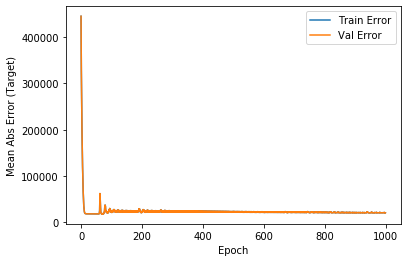

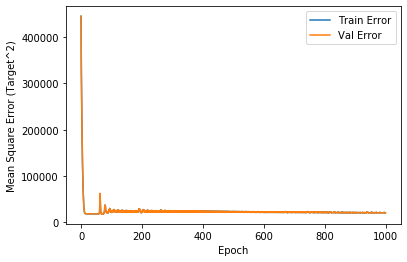

In [9]:
ploting_history(history)

<h2> Checking Evaluation metrics model

In [10]:
    __, mae, __ = model.evaluate(test_data, test_labels, verbose=0)
    print("Test Set Mean Abs Error : {:5.2f} Comodity in ton".format(mae))

Test Set Mean Abs Error : 48397.00 Comodity in ton


<h2> Predicting Test data

In [11]:
predict_result = model.predict(test_data).flatten()

predicted_vs_actual = pd.DataFrame(list(zip(predict_result, test_labels.tolist())), 
               columns =['Prediction','Actual'])

predicted_vs_actual

,Prediction,Actual
0,832329.75,946224
1,877506.75,921824
2,908480.00,919573
3,920852.50,945136


<h2> early stoping 

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stop,PrintDot()])


...............

<h2> Ploting model with early stoping train process

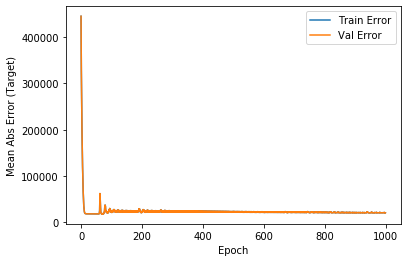

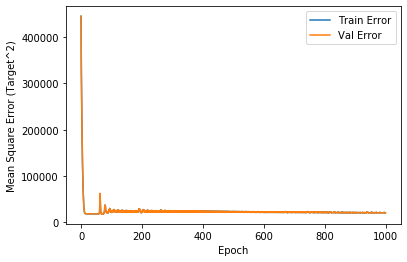

In [13]:
ploting_history(history)

In [14]:
__, mae, __ = model.evaluate(test_data, test_labels, verbose=0)
print("Test Set Mean Abs Error : {:5.2f} Comodity in ton".format(mae))

Test Set Mean Abs Error : 33895.34 Comodity in ton


<h2> Predicting using model with early stoping

In [15]:
predict_result = model.predict(test_data).flatten()

predicted_vs_actual = pd.DataFrame(list(zip(predict_result, test_labels.tolist())), 
               columns =['Prediction','Actual'])

predicted_vs_actual

,Prediction,Actual
0,868414.750,946224
1,914886.375,921824
2,951773.250,919573
3,963770.250,945136
